# Basis

## Query Primary databases

`pyeed` has a set of build in query methods which allow retrieving data from the primary databases such as UniProt and NCBI. Using the `fetch_from_primary_db` or `fetch_nucleotide_from_db` methods, either protein or nucleotide sequences can be retrieved from the primary databases. Besides the sequence, also Gene Ontology, Organism, region, and site annotations are retrieved and added to the database as defined in the `pyeed` graph model.

In [ ]:
from pyeed import Pyeed

uri = "bolt://127.0.0.1:7687"
user = "neo4j"
password = "12345678"

# Create a Pyeed object, automatically connecting to the database
eedb = Pyeed(uri, user, password)


# UniProt IDs of proteins to be fetched from primary database
ids = [
    "P04182",
    "Q6QDP7",
    "P04182",
    "P29758",
    "A0A1G4JJF2",
    "G8ZTZ5",
    "A0A1G4MBD6",
    "A0A7H9HSJ3",
    "J7SA96",
    "G0VK69",
]

# Fetch proteins from primary database
eedb.fetch_from_primary_db(ids)

# number of nodes and edges in db
print(eedb.db.stats())

## Sequence embeddings

The sequence embeddings are generated using Meta's `ESM2` (esm2_t33_650M_UR50D) model. By default, embeddings are calculated in batches of 16 sequences and subsequently added to the database after the calculation.

In [ ]:
# Calculate embeddings for all sequences in the database
eedb.calculate_sequence_embeddings()

## Visualize what's in the DB

To use the web interface, open a browser and go to [`http://localhost:7474/`](http://localhost:7474/).

## Query DB

In [4]:
from pyeed.model import Protein

## Query using pyeed graph objects
# Get all proteins
proteins = Protein.nodes.all()
print("Number of proteins in database: ", len(proteins))

# Get protein with id P04182
protein = Protein.nodes.get(accession_id="P04182")
print(
    f"id: {protein.accession_id} | mol weight: {protein.mol_weight} | ec: {protein.ec_number} | seq length: {protein.seq_length}"
)

## Or execute cypher query
# Get all organisms that have at least one connected proteins
query = """
MATCH (o:Organism)<-[:ORIGINATES_FROM]-(p:Protein)
WITH o, COUNT(p) AS proteinCount
WHERE proteinCount >= 1
RETURN o
"""

organisms = eedb.db.execute_read(query)
print("Number of organisms with at least one protein: ", len(organisms))

# Get 5 most similar proteins to protein with accession_id P04182 based on sequence embedding
query = """
MATCH (p:Protein {accession_id: 'P04182'})
CALL db.index.vector.queryNodes('vector_index_Protein_embedding', 5, p.embedding)
YIELD node AS similarProtein, score
RETURN similarProtein.accession_id AS accession_id, 
       similarProtein.name AS protein_name, 
       score
ORDER BY score DESC
"""

similar_proteins = eedb.db.execute_read(query)
similar_proteins

Number of proteins in database:  44
id: P04182 | mol weight: 48333.0 | ec: 2.6.1.13 | seq length: 439
Number of proteins associated with GO:0005739:  11
Number of organisms with at least two proteins:  9


## Manually add a Protein to the DB

Besides automatically fetching data from the primary databases, it is also possible to manually add a protein to the database. This can be done by creating a `Protein` object and adding it to the database.

For more examples on query and adding data to the database, refere to the [`neomodel` documentation](https://neomodel.readthedocs.io/en/latest/getting_started.html#create-update-delete-operations).

In [ ]:
my_protein = Protein(
    accession_id="12345!",
    name="my_protein",
    seq="MYAYAYAYA",
    seq_length=9,
    mol_weight=2,
)

my_protein.save()

## Use embeddings to plot sequence space in 2D

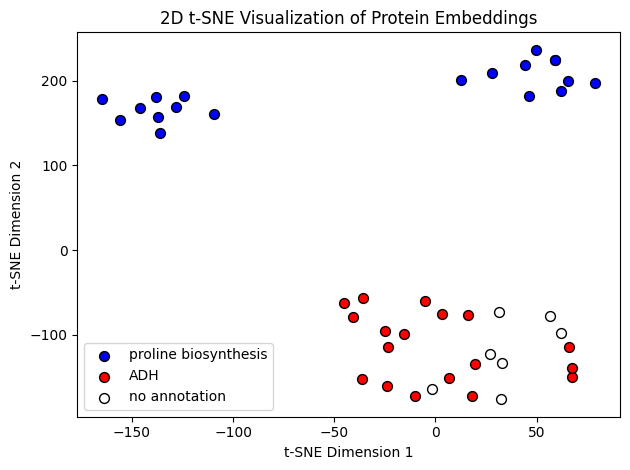

In [6]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Annotations of interest (Alcohol dehydrogenase annotation and proline biosynthesis annotation --> two different protein families)
adh_go_id = "GO:0004022"
ploline_biosynthesis_go_id = "GO:0055129"

# Query to get all proteins with embeddings and get the label based on the annotations
query = """
MATCH (p:Protein)
OPTIONAL MATCH (p)-[:ASSOCIATED_WITH]-(g:GOAnnotation)
WITH p, collect(g.go_id) AS go_ids
RETURN p.accession_id AS protein_id, 
       p.embedding AS embedding,
       CASE 
           WHEN 'GO:0055129' IN go_ids THEN 'proline biosynthesis'
           WHEN 'GO:0004022' IN go_ids THEN 'ADH'
           ELSE 'no annotation'
       END AS label
"""
result = eedb.db.execute_read(query)

# Prepare data for visualization
data = dict(
    protein_id=[],
    embedding=[],
    label=[],
)
for record in result:
    data["protein_id"].append(record["protein_id"])
    data["embedding"].append(record["embedding"])
    data["label"].append(record["label"])

protein_ids, embeddings, labels = (
    data["protein_id"],
    np.array(data["embedding"]),
    data["label"],
)

colors = []
for label in labels:
    if label == "ADH":
        colors.append("red")
    elif label == "proline biosynthesis":
        colors.append("blue")
    else:
        colors.append("white")

# Apply t-SNE to Reduce Embeddings to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=5, max_iter=3000)
embeddings_2d = tsne.fit_transform(embeddings)

# Create a scatter plot for each unique label
unique_labels = set(labels)
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        [embeddings_2d[i, 0] for i in indices],
        [embeddings_2d[i, 1] for i in indices],
        c=[colors[indices[0]]],  # Set the color for the group
        label=label,
        s=50,  # Marker size
        edgecolor="k",  # Add an edge color for better visibility
    )

plt.title("2D t-SNE Visualization of Protein Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.tight_layout()
plt.show()

## Mutation Relationship

Besides Nodes, Relationships can also have properties.
There now exists a `Mutation` property, representing a single mutation between two `DNA` or `Protein` nodes.
The `validate_and_connect` class method can be used to create, validate, and connect a `Mutation` relationship between two `DNA` or `Protein` nodes.

In [7]:
from pyeed.model import Mutation

# Find all mutations between two proteins
p1 = Protein.nodes.get(accession_id="P04182")
p2 = Protein.nodes.get(accession_id="P29758")

for position, (seq1_pos, seq2_pos) in enumerate(zip(p1.sequence, p2.sequence)):
    if seq1_pos != seq2_pos:
        Mutation.validate_and_connect(
            molecule1=p1,
            molecule2=p2,
            from_position=position,
            to_position=position,
            from_monomer=seq1_pos,
            to_monomer=seq2_pos,
        )

In [8]:
# Close the connection to the database
eedb.db.close()

🔌 Connection closed.
